In [1]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import math

In [43]:
M, N, K = 80, 100, 15

In [44]:
lamb, C_fit, beta = 0.75, 1.5, 0.95

In [128]:
h = K/3# 0 < h < k/2
p_mut = 0.35
T_stop = 500

In [113]:
def generateMatrices(N, M, K):
    #Генерация W_trait - матрица MxN весов для вычисления f_i(s) = sigmoid(sum(w_i_j*s_j) - h_i)
    #Распределние Пуассона ненулевых весов M фенотипов
    poisson_distr = np.random.poisson(K, size=(N,))
    
    #Проверка на то, что среднее количество ненулевых весов равно K
    print("Average non-zero:", np.absolute(poisson_distr.mean()))
    print("Weights M vector for M traits: ", poisson_distr)
    
    W_trait = np.zeros((N,M))
    for i in range(N):
        #Генирируем -1 и 1
        weights = np.random.choice([1,-1], size=poisson_distr[i], p=[0.5, 0.5])
        #Создаём последовательности N - ki нулей
        weights = np.concatenate( (weights, np.zeros( (M - poisson_distr[i], ) ) ) )
        #Делаем перестановку
        weights = np.random.permutation(weights)
        W_trait[i] = weights
    W_trait = W_trait.astype(int)

    
    #Генерация B
    B = np.random.uniform(low=0.0, high=3.0, size=(M,M))
    B = np.tril(B) + np.tril(B, -1).T
    
    #Генерация C
    C = np.random.uniform(low=0.0, high=3.0, size=(M,))
    
    return (W_trait, B, C)

In [66]:
def generateGenPool(N, N_pop):
    s = np.random.choice([0,1], (N, N_pop))
    return s

In [67]:
def mutate(s, N, N_pop, p_mut):
    #print(s.reshape(-1, ))
    for i in range(N_pop):
        for j in range(N):
            r = np.random.sample()
            if (r <= p_mut):
                s[j, i] = 1 - s[j, i]
    #print(s.reshape(-1, ))
    return s            

In [124]:
#Вычисляет вектор, в котором каждый элемент это значение функции
#f_j(s) = sigmoid(sum(w_j_i*s_i) - h)
def TraitPotential(W, s, h, M, N):
    F = np.zeros(M, )
    for j in range(M):
        f_j = 0
        for i in range(N):
            #f_j += W[j][i]*s[i] - h
            
            #h*s[i]^2 добавлено, чтобы не накапливалось отрицательное значение на 0ых генах
            #f_j += W[j][i]*s[i] - h*(s[i]**2)
            
            f_j += W[i][j]*s[i]
        
        #Сигомида
    #    print(f_j)
        f_j = f_j - h
       # print(f_j)
      #  F[j] = np.heaviside(f_j, 0.5)
        #F[j] = 1 / (1 + np.exp(-f_j))
      #  print(F[j])
    return F

In [119]:
def Fitness(B, C, s, W_trait, h, C_fit, lamb):
    F = TraitPotential(W_trait, s, h, M, N)
    W = np.dot((B@F), F)/2 + np.dot(C, F)
   # print(W)
#     W = 0
#     for i in range(M):
#         for j in range(M):
#             W += B[i][j]*F[j]
#     W *= 0.5
#     for i in range(M):
#         W += C[i]*F[i]
    return C_fit*np.exp(lamb*W)

In [120]:
def SSWM(M, N, K, lamb, C_fit, beta, h, p_mut, T_stop, W, B, C, N_pop):
    C = C.reshape(-1,)
    Fitness_vals = []
    W_max = np.dot(((linalg.inv(B))@C), C)
    W_max = W_max * (-0.5)
    F_max = C_fit*np.exp(W_max*lamb)
    
    s = generateGenPool(N, N_pop)
    F = Fitness(B, C, s, W_trait, h, C_fit, lamb)
    T = 0
    print(F_max , F)
    while (T < T_stop and beta*F < beta*F_max):
        F = Fitness(B, C, s, W_trait, h, C_fit, lamb)
        Fitness_vals.append(F)
        
        s_mut = mutate(s, N, N_pop, p_mut)
        F_mut = Fitness(B, C, s_mut, W_trait, h, C_fit, lamb)
        if (F_mut > F):
            s = s_mut
        #print(F)
        T += 1
    
    plt.plot(range(T), Fitness_vals)
    plt.show()
  #  print(Fitness_vals)
  #  print(max(Fitness_vals))

In [129]:
W_trait, B, C = generateMatrices(N, M, K)
print("W_trait matrix:\n", W_trait, sep="")

#Подсчёт кол-ва -1, 1, 0
unique, counts = np.unique(W_trait, return_counts=True)
print(dict(zip(unique, counts)))

Average non-zero: 15.31
Weights M vector for M traits:  [10 11 12 11 20 21 16 15 18 20 19 20 12 10 13 13  8 19 12 13 10 20 21 21
 19 15 13 27 15 16 11 19 17 15 13 21  9 14 17 17 17 12 22 15 14 14 12 19
 27 18 16 14 12 15 16 11 17 21 13 12 16 18 13 16 17 14 14  7 21 14 14 18
 13 13 14 18 16 16 12 11 10 15 15 13 13 10 16 16 15 16 21 11 15 20 17 13
 15 16 18 11]
W_trait matrix:
[[ 0  0  0 ...  0  0 -1]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]
{-1: 787, 0: 6469, 1: 744}


3.551615003590772 1.5


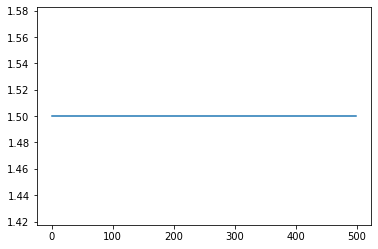

In [130]:
SSWM(M, N, K, lamb, C_fit, beta, h, p_mut, 500, W_trait, B, C,N_pop=1)

In [123]:
poisson_distr = np.random.poisson((K*M)/N, (M, N))
print(poisson_distr)
print("Average non-zero:", np.absolute(poisson_distr.mean()))

[[10 12 15 ... 12 12 11]
 [18 17 12 ... 15 11 19]
 [14 14 11 ... 10 13 20]
 ...
 [13 11 18 ... 14 14  8]
 [13 22 11 ... 16 13 13]
 [11  7 13 ... 12 10 11]]
Average non-zero: 11.98975
